# `true-intent` Destination Classification

We provide 3 benchmarks for the 7-class multi-class classification of `destination` column in `truevoice-intnet` dataset: LinearSVC and [ULMFit](https://github.com/cstorm125/thai2fit). In the transfer learning cases, we first finetune the embeddings using all data. The test set contains 20% of all data split by [TrueVoice](http://www.truevoice.co.th/). The rest is split into 85/15 train-validation split randomly. Performance metrics are micro-averaged and macro-averaged accuracy and F1 score.

| model     | macro-accuracy | micro-accuracy | macro-F1       | micro-F1   |
|-----------|----------------|----------------|----------------|------------|
| **LinearSVC** | **0.957806**       | **0.95747712**     |       **0.869411** | **0.85116993** |
| ULMFit    | 0.955066       | 0.84273111     | 0.852149       | 0.84273111 |
| USE    | 0.943559       | 0.94355855    | 0.787686       | 0.802455 |

In [0]:
# #colab
# !wget https://github.com/PyThaiNLP/truevoice-intent/archive/master.zip; unzip master.zip; cd truevoice-intent-master; unzip mari-intent.zip; cp *.* ../;
# !mkdir ft_data
# !mkdir truevoice_data
# !pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install emoji
# !pip install tensorflow_text
!ls

class_features.py     mari-test-balanced.csv   sample_data
classification.ipynb  mari-train-balanced.csv  thsarabunnew-webfont.ttf
exploration.ipynb     master.zip	       truevoice_data
ft_data		      README.md		       truevoice-intent-master
mari-intent.zip       remove-dup-split.ipynb


In [0]:
import pandas as pd
import numpy as np
from pythainlp import word_tokenize
from tqdm import tqdm_notebook
from collections import Counter
import re
from sklearn.metrics import f1_score,precision_score,recall_score

#viz
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

def replace_newline(t):
    return re.sub('[\n]{1,}', ' ', t)

ft_data = 'ft_data/'

y = 'destination'
nb_class = 7

In [0]:
import string
import emoji
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    #tokenize
    res = [word for word in res.split('|') if word and not re.search(pattern=r"\s+", string=word)]
    
    #post rules
    res = ungroup_emoji(res)
    
    return res

## Train-validation-test Split

We perform 85/15 train-validation split in addition to the test split by [TrueVoice](http://www.truevoice.co.th/).

In [0]:
from sklearn.model_selection import train_test_split
all_df = pd.read_csv(f'mari-train-balanced.csv')
all_df['destination'] = all_df.destination.map(lambda x: x.replace(' ','_'))
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = pd.read_csv(f'mari-test-balanced.csv')
test_df['destination'] = test_df.destination.map(lambda x: x.replace(' ','_'))
print(train_df.shape, valid_df.shape, test_df.shape)

(8757, 5) (1546, 5) (2607, 5)


In [0]:
#test set prevalence
test_df['destination'].value_counts() / test_df.shape[0]

billing_and_payment      0.376678
promotions               0.220560
other_queries            0.176064
internet                 0.154200
international_dialing    0.034522
true_money               0.019946
lost_and_stolen          0.018028
Name: destination, dtype: float64

## LinearSVC Model

Code for LinearSVC is provided by [@lukkiddd](https://github.com/lukkiddd).

In [0]:
X_train, y_train = train_df['texts'], train_df[y]
X_test, y_test = test_df['texts'], test_df[y]

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1,2))),
    ('clf', LinearSVC(class_weight='balanced')),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function word_tokenize at 0x7fc57387b0d0>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight='balanced', dual=True,
                           fit_intercep

In [0]:
pred = text_clf.predict(X_test)
(pred==y_test).mean()

0.8523206751054853

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
pred_lab = text_clf.predict(X_test)

enc_fit = enc.fit(test_df[y][:,None])
pred_ohe = enc_fit.transform(pred_lab[:,None]).toarray()
y_ohe = enc_fit.transform(test_df[y][:,None]).toarray()

In [0]:
import warnings
warnings.filterwarnings("ignore")

ds = []

#macro metrics
for i in range(nb_class):
    ds.append({'acc':(pred_ohe[:,i]==y_ohe[:,i]).mean(),
               'f1':f1_score(pred_ohe[:,i],y_ohe[:,i]),
               'precision':precision_score(pred_ohe[:,i],y_ohe[:,i]),
               'recall':recall_score(pred_ohe[:,i],y_ohe[:,i])})
    print(
        (pred_ohe[:,i]==y_ohe[:,i]).mean(),
        f1_score(pred_ohe[:,i],y_ohe[:,i]),
        precision_score(pred_ohe[:,i],y_ohe[:,i]),
        recall_score(pred_ohe[:,i],y_ohe[:,i])
         )

0.9182968929804373 0.890036138358286 0.8778004073319755 0.9026178010471204
0.9934790947449176 0.9050279329608939 0.9 0.9101123595505618
0.9278864595320292 0.7745803357314148 0.8034825870646766 0.7476851851851852
0.9969313387034906 0.9166666666666666 0.9361702127659575 0.8979591836734694
0.935174530111239 0.8086070215175537 0.7777777777777778 0.8419811320754716
0.9355581127733027 0.8576271186440678 0.88 0.8363636363636363
0.9973149213655543 0.9333333333333333 0.9423076923076923 0.9245283018867925


In [0]:
pd.DataFrame(ds).mean()

acc          0.957806
f1           0.869411
precision    0.873934
recall       0.865893
dtype: float64

In [0]:
print('micro metrics')
(pred_ohe==y_ohe).mean(), \
f1_score(y_ohe,pred_ohe,average='micro'), \
precision_score(y_ohe,pred_ohe,average='micro'), \
recall_score(y_ohe,pred_ohe,average='micro')

micro metrics


(0.9574771220340841,
 0.8511699271192942,
 0.8511699271192942,
 0.8511699271192942)

## [ULMFit](https://github.com/cstorm125/thai2fit) Model

In [0]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback

from pythainlp.ulmfit import *

model_path = 'truevoice_data/'

Corpus: wiki_lm_lstm
- Downloading: wiki_lm_lstm 0.32


100%|██████████| 1050919089/1050919089 [00:47<00:00, 21901908.08it/s]


Corpus: wiki_itos_lstm
- Downloading: wiki_itos_lstm 0.32


100%|██████████| 1530484/1530484 [00:00<00:00, 23321338.99it/s]


In [0]:
from sklearn.model_selection import train_test_split
all_df = pd.read_csv(f'mari-train-balanced.csv')
all_df['destination'] = all_df.destination.map(lambda x: x.replace(' ','_'))
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = pd.read_csv(f'mari-test-balanced.csv')
test_df['destination'] = test_df.destination.map(lambda x: x.replace(' ','_'))
print(train_df.shape, valid_df.shape, test_df.shape)
all_df = pd.concat([all_df,test_df]).reset_index(drop=True)

(8757, 5) (1546, 5) (2607, 5)


### Finetune Language Model

In [0]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
# processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
#             NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

# data_lm = (TextList.from_df(all_df, model_path, cols=['texts'], processor=processor)
#     .random_split_by_pct(valid_pct = 0.01, seed = 1412)
#     .label_for_lm()
#     .databunch(bs=64))
# data_lm.sanity_check()
# data_lm.save('truevoice_lm.pkl')

In [0]:
data_lm = load_data(model_path,'truevoice_lm.pkl')
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(12781, 129)

In [0]:
data_lm.show_batch(5)

idx,text
0,อยาก ทราบ ว่า ยอด ที่ ชำระ เหลือ เท่าไหร่ คะ ยอด ที่ ค้างชำระ ค่ะ xxbos สมัคร อินเตอร์เน็ต xxunk เท่าไหร่ บ้าง ค่ะ xxbos ครับ คือ ผม จะ เรียน สอบถาม ครับ เกี่ยวกับ อินเตอร์เน็ต ครับ ของ ผม มัน ได้ gb ครับ อยาก สอบถาม ของ ผม ใช้ ไป เท่าไร แล้ว ครับ xxbos สอบถาม
1,ให้ เปิด สัญญาณ หน่อย ค่ะ xxbos คะ จะ เช็ค ยอด ใช้งาน อินเตอร์เนต คะ xxbos ไม่มี สัญญาณ เอ จ / จี พีอาร์ เอส / สาม จี เลย xxbos ขอ เปิด สัญญาณ ก่อน xxbos ว่า จะ ถาม โปร จะ สมัคร โปร xxunk แอ พ มี หรือไม่ ค่ะ xxbos
2,ใช้ บริการ ไม่ได้ ครับ xxbos พี่ จะ เปิด โรม มิ่ง ไป มาเลเซีย ค่ะ xxbos สวัสดี คะ พี่ จะ สอบถาม ใบแจ้งหนี้ ปัจจุบัน ว่า ยอด พี่ xxunk ค้าง อยู่ เท่า ไห ร พี่ xxunk ว่า ไป จ่าย บ้าง หรือยัง xxbos จะ ยกเลิก xxunk ค่ะ xxbos ต้องการ xxunk
3,สอบถาม เรื่อง การระงับ โทร ออก อ่ะ พี่ xxbos หมายเลข นี้ มัน ตัด เน๊ต หรือ มัน ตัด อะไร แล้ว เหรอ ครับ xxbos พี่ คะ หนู จะ สอบถาม ว่า หนู ใช้ ท รู มูฟ เอ ช เป็น air card มีค่า อะไร บาท xxbos ครับ สอบถาม การ เติม เงิน หน่อย ครับ คือ บัตรเติมเงิน
4,โทรศัพท์ บีบี ใช้ ไหม แล้ว เล่น ไลน์ ได้ ไหม xxbos อินเตอร์เน็ต ที่ ตัด ไป ค้าง กี่ เดือน คะ xxbos เคย แจ้ง ยกเลิก sms ไป แต่ ตอนนี้ ยัง มี ส่ง มา อยู่ ครับ xxbos อยาก ทราบ ว่า ทำไม เข้าไป เล่น เน็ต ไม่ได้ ครับ xxbos ขอ ทราบ ยอดเงิน คงเหลือ ครับ xxbos


In [0]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**THWIKI_LSTM)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (12781 items)
x: LMTextList
xxbos   สอบถาม   package   internet   ว่า มี แบบ ไหน บ้าง ครับ,xxbos   ค่ะ   พี่ ค่ะ   คือ อยู่ ๆ   เน็ต เล่น ไม่ได้ อ่ะ ค่ะ,xxbos   การ เปลี่ยน   ระบบ จาก   ท รู   เป็น   ท รู เอ ช   มี ค่าบริการ ด้วย หรอ ค่ะ,xxbos   เช็ค ให้ หน่อย ได้ ไหม ครับ   ว่า เบอร์ ของ ผม   เปลี่ยนเป็น บุฟเฟ่ต์   บาท รึ ยัง,xxbos   จะ โทร แจ้ง xxunk ซิม อ่ะ ค่ะ   ซิม หาย
y: LMLabelList
,,,,
Path: truevoice_data;

Valid: LabelList (129 items)
x: LMTextList
xxbos   พอดี จะ สอบถาม อินเตอร์ ว่า ใช้งาน ได้ รึ ยัง,xxbos   มี   sms   เข้า   แจ้ง ว่า ถูก คิด ค่าบริการ จาก   gprs   อะ ค่ะ,xxbos   อยาก สมัคร แพ็ค แก xxunk รู วาย ฟาย แบบ รายเดือน ค่ะ,xxbos   ผม ค้นหา xxunk ทู xxunk แล้ว ค้นหา อุปกรณ์ ไม่ เจอ   มัน เป็น เพราะอะไร ครับ,xxbos   ยกเลิก บริการ แล้วแต่ ทำไม ยัง มี   xxunk   /   ยอด เรียก เก็บ อีก
y: LMLabelList
,,,,
Path: truevoice_data;

Test: None, model=SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1648, 400, padd

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


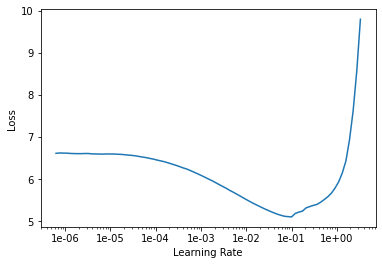

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
len(learn.data.vocab.itos)

1648

In [0]:
#train frozen
print('training frozen')
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy,time
0,6.088318,5.605548,0.216295,00:09


In [0]:
#train unfrozen
print('training unfrozen')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,5.552826,4.931184,0.225893,00:13
1,4.979910,4.119917,0.283259,00:13
2,4.472735,3.767354,0.319196,00:12
3,4.147000,3.611560,0.336607,00:13
4,3.933862,3.511489,0.343527,00:12
5,3.808146,3.460953,0.347545,00:12
6,3.727168,3.431783,0.351339,00:12
7,3.676329,3.410134,0.352009,00:13
8,3.646956,3.405561,0.353571,00:12
9,3.627930,3.407281,0.353571,00:13


In [0]:
learn.save('truevoice_lm')
learn.save_encoder('truevoice_enc')

### Classification

In [0]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=3)]

train_df = pd.read_csv(f'mari-train-balanced.csv')
train_df['destination'] = train_df.destination.map(lambda x: x.replace(' ','_'))

data_cls = (TextList.from_df(train_df, model_path, cols=['texts'], processor=processor)
    .random_split_by_pct(valid_pct = 0.05, seed = 1412)
    .label_from_df('destination')
    .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
    .databunch(bs=64)
    )

data_cls.sanity_check()
data_cls.save('truevoice_cls.pkl')

In [0]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(bptt=70, drop_mult=0.5, alpha=2, beta=1)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_func = partial(optim.Adam, betas=(0.7, 0.99))

#load pretrained finetuned model
learn.load_encoder('truevoice_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (9788 items)
x: TextList
xxbos   สอบถาม   package   internet   ว่า มี แบบ ไหน บ้าง ครับ,xxbos   ค่ะ   พี่ ค่ะ   คือ อยู่ ๆ   เน็ต เล่น ไม่ได้ อ่ะ ค่ะ,xxbos   การ เปลี่ยน   ระบบ จาก   ท รู   เป็น   ท รู เอ ช   มี ค่าบริการ ด้วย หรอ ค่ะ,xxbos   เช็ค ให้ หน่อย ได้ ไหม ครับ   ว่า เบอร์ ของ ผม   เปลี่ยนเป็น บุฟเฟ่ต์   บาท รึ ยัง,xxbos   จะ โทร แจ้ง xxunk ซิม อ่ะ ค่ะ   ซิม หาย
y: CategoryList
promotions,internet,promotions,promotions,lost_and_stolen
Path: truevoice_data;

Valid: LabelList (515 items)
x: TextList
xxbos   ทำไม ไม่ สามารถ ทำการ เติม เงินได้ ค่ะ,xxbos   ชำระ ยอด มา แล้ว   บาท   ตอนนี้ มี ยอด ค้าง อยู่ ไหม,xxbos   ได้ จดหมาย ของ ทรูวิชั่น   แต่ ไป ชำระ ค่าบริการ มา แล้ว   จะ เช็ค ว่า ทำไม ถึง มี ใบ แจ้ง เข้ามา ค่ะ,xxbos   เบอร์ นี้ สมัคร เป็น โปร อะไร ครับ,xxbos   จะ ยกเลิก บริการ   sms   ค่ะ
y: CategoryList
true_money,billing_and_payment,billing_and_payment,promotions,other_queries
Path: truevoice_data;

Test: LabelList (2607 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


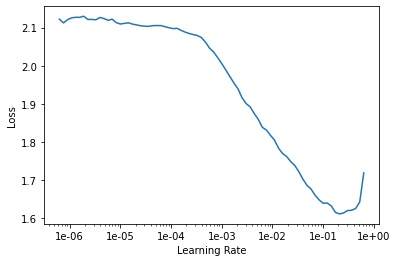

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#train unfrozen
learn.freeze_to(-1)
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.825627,0.755235,0.724272,00:05


In [0]:
#gradual unfreezing
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7), 
                   callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='truevoice_cls')])

epoch,train_loss,valid_loss,accuracy,time
0,0.646933,0.625633,0.782524,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.513058,0.525635,0.823301,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.351930,0.511117,0.821359,00:14
1,0.289966,0.506727,0.840777,00:15
2,0.198917,0.518295,0.836893,00:16


Better model found at epoch 0 with accuracy value: 0.8213592171669006.
Better model found at epoch 1 with accuracy value: 0.8407766819000244.


In [0]:
probs, y_true = learn.get_preds(ds_type = DatasetType.Test, ordered=True)
classes = learn.data.train_ds.classes
y_true = np.array([classes[i] for i in y_true.numpy()])
preds = np.array([classes[i] for i in probs.argmax(1).numpy()])
prob = probs.numpy()

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

enc_fit = enc.fit(test_df[y][:,None])
pred_ohe = enc_fit.transform(preds[:,None]).toarray()
y_ohe = enc_fit.transform(test_df[y][:,None]).toarray()

In [0]:
import warnings
warnings.filterwarnings("ignore")

ds = []

#macro metrics
for i in range(nb_class):
    ds.append({'acc':(pred_ohe[:,i]==y_ohe[:,i]).mean(),
               'f1':f1_score(pred_ohe[:,i],y_ohe[:,i]),
               'precision':precision_score(pred_ohe[:,i],y_ohe[:,i]),
               'recall':recall_score(pred_ohe[:,i],y_ohe[:,i])})
    print(
        (pred_ohe[:,i]==y_ohe[:,i]).mean(),
        f1_score(pred_ohe[:,i],y_ohe[:,i]),
        precision_score(pred_ohe[:,i],y_ohe[:,i]),
        recall_score(pred_ohe[:,i],y_ohe[:,i])
         )

0.9117759877253548 0.8847695390781563 0.8991853360488798 0.8708086785009862
0.9942462600690449 0.9142857142857143 0.8888888888888888 0.9411764705882353
0.9286536248561565 0.7680798004987532 0.7661691542288557 0.77
0.9957805907172996 0.8764044943820225 0.8297872340425532 0.9285714285714286
0.9301879555044112 0.7912844036697246 0.7516339869281046 0.8353510895883777
0.9290372075182202 0.8436179205409974 0.8678260869565217 0.8207236842105263
0.9957805907172996 0.88659793814433 0.8269230769230769 0.9555555555555556


In [0]:
#macro statistics
pd.DataFrame(ds).mean()

acc          0.955066
f1           0.852149
precision    0.832916
recall       0.874598
dtype: float64

In [0]:
print('micro metrics')
(preds==test_df[y]).mean(), \
f1_score(test_df[y],preds,average='micro'), \
precision_score(test_df[y],preds,average='micro'), \
recall_score(test_df[y],preds,average='micro')

micro metrics


(0.8427311085538933,
 0.8427311085538933,
 0.8427311085538933,
 0.8427311085538933)

## [Multilingual Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3)

Multilingual universal sentence encoder produces 512 embeddings that represent each sentence. We use those features to predict the labels.

In [0]:
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf #tensorflow 2.1.0

enc = hub.load('https://tfhub.dev/google/universal-sentence-encoder-multilingual/3')

In [0]:
train_df.shape, valid_df.shape, test_df.shape

((8757, 5), (1546, 5), (2607, 5))

In [0]:
X_train = enc(train_df.texts).numpy()
X_valid = enc(valid_df.texts).numpy()
X_test = enc(test_df.texts).numpy()
X_train.shape, X_valid.shape, X_test.shape

((8757, 512), (1546, 512), (2607, 512))

In [0]:
y_train, y_valid, y_test = train_df[y], valid_df[y], test_df[y]
y_train.shape, y_valid.shape, y_test.shape

((8757,), (1546,), (2607,))

In [0]:
from sklearn.svm import LinearSVC

text_clf = LinearSVC(class_weight='balanced')
text_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
pred = text_clf.predict(X_test)
(pred==y_test).mean()

0.8024549290372075

In [0]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
pred_lab = text_clf.predict(X_test)

enc_fit = enc.fit(test_df[y][:,None])
pred_ohe = enc_fit.transform(pred_lab[:,None]).toarray()
y_ohe = enc_fit.transform(test_df[y][:,None]).toarray()

In [0]:
import warnings
warnings.filterwarnings("ignore")

ds = []

#macro metrics
for i in range(nb_class):
    ds.append({'acc':(pred_ohe[:,i]==y_ohe[:,i]).mean(),
               'f1':f1_score(pred_ohe[:,i],y_ohe[:,i]),
               'precision':precision_score(pred_ohe[:,i],y_ohe[:,i]),
               'recall':recall_score(pred_ohe[:,i],y_ohe[:,i])})
    print(
        (pred_ohe[:,i]==y_ohe[:,i]).mean(),
        f1_score(pred_ohe[:,i],y_ohe[:,i]),
        precision_score(pred_ohe[:,i],y_ohe[:,i]),
        recall_score(pred_ohe[:,i],y_ohe[:,i])
         )

0.8853087840429612 0.8417151932239281 0.8095723014256619 0.87651598676957
0.9907940161104718 0.8723404255319148 0.9111111111111111 0.8367346938775511
0.9148446490218642 0.74364896073903 0.8009950248756219 0.6939655172413793
0.9911775987725355 0.7722772277227723 0.8297872340425532 0.7222222222222222
0.9163789796701189 0.7528344671201814 0.7233115468409586 0.7848699763593381
0.9202148062907557 0.8213058419243986 0.831304347826087 0.8115449915110357
0.9861910241657077 0.7096774193548387 0.8461538461538461 0.6111111111111112


In [0]:
pd.DataFrame(ds).mean()

acc          0.943559
f1           0.787686
precision    0.821748
recall       0.762423
dtype: float64

In [0]:
print('micro metrics')
(pred_ohe==y_ohe).mean(), \
f1_score(y_ohe,pred_ohe,average='micro'), \
precision_score(y_ohe,pred_ohe,average='micro'), \
recall_score(y_ohe,pred_ohe,average='micro')

micro metrics


(0.9435585511534879,
 0.8024549290372075,
 0.8024549290372075,
 0.8024549290372075)